# PV Forecast using historical data and weather forecasts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (20,8)

from solar.datasets import client_data, create_forecast_df, train_test_split
import solar.features as feats
from solar.training import train_multiple_steps, CreateModel

### Constructing shifted features 

Each shifting step represent 15 minutes

In [2]:
SHIFTS = [1, 2, 4, 8, 16, 24, 48, 96]
sites = ["Bastorf"]

def data_pre(df):
    return df.fillna(0)

def data_post(df):
    # Only rows with non-null in all columns
    df = df[~df.isnull().any(axis=1)]
    #Ignore everything below 7kW
    # df = df[df["target"] > 7000]
    return df

print("Reading sites: ", sites)    
datasets = {    
    k: feats.ShiftedFeatures(    
        client_data[k].df,    
        data_pre_fn=data_pre,    
        data_post_fn=data_post,    
        shift_features_fn=feats.shifted_features_target,    
        fixed_features_fn=feats.fixed_features,    
        location=client_data[k].__dict__,    
    ) for k in sites    
}    

print("Creating training data")    
training_data = feats.TrainingData(datasets)    

Reading sites:  ['Bastorf']
Creating training data


### Setup training data 
The data is filtered for a certain timeframe. Also, the forecast data is resampled to 15 minute windows. Then the features of the historical data are combined with the forecast.

In [3]:

shift = 36
start_date = "2021-11-16"
end_date = "2023-04-01"
Bast_train_data = datasets["Bastorf"].data(shift)
Bast_train_data.index = Bast_train_data.index.tz_convert(None).to_series().astype('datetime64[ns]')
Bast_train_data = Bast_train_data[(Bast_train_data.index >= pd.to_datetime(start_date)) & (Bast_train_data.index < pd.to_datetime(end_date))]


# forecast data for Bastorf
weather_fc = pd.read_parquet("data/Bastorf_01012021-15052020_36steps.parquet")
weather_fc = create_forecast_df(weather_fc, shift, forecasts_per_day=2 , index=1, start_date=start_date, end_date=end_date, diff=True)

# add measurements to the forecast data
measurements = pd.read_csv("data/csv_electricity_informatics.csv")
measurements["MESS_DATUM"] = pd.to_datetime(measurements["MESS_DATUM"], format="%Y%m%d%H%M")
# filter for the time period
measurements = measurements[(measurements["MESS_DATUM"] >= pd.to_datetime(start_date)) & (measurements["MESS_DATUM"] < pd.to_datetime(end_date))]
# account for the shift
measurements = measurements.iloc[shift:]
new_rows = pd.DataFrame(0, index=range(shift), columns=measurements.columns)
measurements = pd.concat([measurements, new_rows]).reset_index(drop=True)
measurements["GS_10"] = measurements["GS_10"].apply(lambda x: max(x, 0))

# add measurements to the train dataframe


# combine measurements, historical and forecast data
Bast_train_data["ssrd_diff"] = weather_fc["ssrd_diff"].values
Bast_train_data["ssr_diff"] = weather_fc["ssr_diff"].values
Bast_train_data["measurements"] = measurements["GS_10"].values
#Bast_train_data["valid_time"] = weather_fc["valid_time"].values
#Bast_train_data["time"] = weather_fc["time"].values
# Bast_train_data = Bast_train_data[Bast_train_data["target"] > 7000]


#construct training and test datasets
train_df, test_df = train_test_split(Bast_train_data, shift_steps=shift, train_split=0.8) 

(64380, 7)
(64380, 9)
(40774, 9)
(37074, 9)
32400000000000
75600000000000.0
(12024, 9)
   time  step  number  surface  latitude  longitude  valid_time  ssr_diff  \
0     0     0       0        0         0          0           0         0   

   ssrd_diff  
0          0  
(48095, 9)
(48096, 9)


### Train model with only historical features

In [4]:
feat_cols = train_df.columns.drop("target").drop("ssrd_diff").drop("ssr_diff").drop("measurements")
feature_selector = ColumnTransformer(
        [("selector", "passthrough", feat_cols)],
        remainder="drop",
        )
model = Pipeline(
                [
                    ("column_selector", feature_selector),
                    ("scaler", StandardScaler()),
                    ("model", XGBRegressor(scoring=make_scorer(mean_absolute_error, greater_is_better=False))),
                ]
            )


model.fit(train_df[feat_cols], train_df["target"])
ytrue = test_df["target"]

In [5]:
# Make predictions
y_pred_hist = model.predict(test_df[feat_cols])

# Calculate metrics
mse = mean_squared_error(test_df["target"], y_pred_hist)
mae = mean_absolute_error(test_df["target"], y_pred_hist)
r2 = r2_score(test_df["target"], y_pred_hist)

# Print metrics
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)


Mean Squared Error: 298311617.37212914
Mean Absolute Error: 7581.60087534683
R-squared: 0.3034168231600447


In [6]:
# Retrieve feature importances from the fitted model
feature_importances = model.named_steps["model"].feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feat_cols,
    'Importance': feature_importances
})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
print(importance_df[:50])

                 Feature  Importance
80               irr_tar    0.600007
73    p_period7D_max_tar    0.118936
74   p_period7D_mean_tar    0.025957
56               doy_cos    0.025625
53                   doy    0.017974
19             p_24H_std    0.012697
24              p_7D_std    0.012429
27             p_28D_max    0.011266
17             p_24H_max    0.009700
28            p_28D_mean    0.009562
18            p_24H_mean    0.009546
57               doy_sin    0.009413
29             p_28D_std    0.007678
69    p_period5D_max_tar    0.007678
23             p_7D_mean    0.007656
22              p_7D_max    0.007193
65    p_period2D_max_tar    0.006388
58               tod_cos    0.005645
50  p_period28D_mean_now    0.005074
44    p_period7D_min_now    0.004930
77   p_period28D_max_tar    0.004682
41    p_period5D_max_now    0.003750
70   p_period5D_mean_tar    0.003668
48   p_period28D_min_now    0.003503
36    p_period2D_min_now    0.003484
68    p_period5D_min_tar    0.003273
4

### Train model with forecast features

In [7]:
feat_cols = train_df.columns.drop("target").drop("measurements")
feature_selector = ColumnTransformer(
        [("selector", "passthrough", feat_cols)],
        remainder="drop",
        )
model = Pipeline(
                [
                    ("column_selector", feature_selector),
                    ("scaler", StandardScaler()),
                    ("model", XGBRegressor(scoring=make_scorer(mean_absolute_error, greater_is_better=False))),
                ]
            )


model.fit(train_df[feat_cols], train_df["target"])


Pipeline(steps=[('column_selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  Index(['p', 'p_1H_min', 'p_1H_max', 'p_1H_mean', 'p_1H_std', 'p_1H_count',
       'p_2H_min', 'p_2H_max', 'p_2H_mean', 'p_2H_std', 'p_2H_count',
       'p_6H_min', 'p_6H_max', 'p_6H_mean', 'p_6H_std', 'p_6H_count',
       'p_24H_min', 'p_24H_max', 'p_24H_mean', 'p_24H_std', 'p_24H_count',
       'p_7D_min...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [8]:
# Make predictions
ypred_ff = model.predict(test_df[feat_cols])

# Calculate metrics
mse = mean_squared_error(test_df["target"], ypred_ff)
mae = mean_absolute_error(test_df["target"], ypred_ff)
r2 = r2_score(test_df["target"], ypred_ff)

# Print metrics
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)


Mean Squared Error: 142511365.25351945
Mean Absolute Error: 4856.790778773058
R-squared: 0.6672237560890562


In [9]:
# Retrieve feature importances from the fitted model
feature_importances = model.named_steps["model"].feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feat_cols,
    'Importance': feature_importances
})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
print(importance_df)

                  Feature  Importance
81              ssrd_diff    0.499489
82               ssr_diff    0.167766
38    p_period2D_mean_now    0.036755
80                irr_tar    0.023646
49    p_period28D_max_now    0.015847
..                    ...         ...
47   p_period7D_count_now    0.000000
16              p_24H_min    0.000000
51  p_period28D_count_now    0.000000
61     p_period1D_max_tar    0.000000
10             p_2H_count    0.000000

[83 rows x 2 columns]


### Train model with forecast features and with Grid Search

In [10]:
feat_cols = train_df.columns.drop("target").drop("measurements")
feature_selector = ColumnTransformer(
        [("selector", "passthrough", feat_cols)],
        remainder="drop",
        )

param_grid = {    
    #"min_child_weight": [1, 2], #1    
    #"n_estimators": [100, 200], #100    
    "n_estimators": [10], #100    
    #"gamma": [1.5],    
    #"subsample": [0.6],    
    #"colsample_bytree": [0.8, 1], #1    
    #"max_depth": [4, 6], #6    
    #"learning_rate": [0.1, 0.3], #0.3    
}  

model = Pipeline(
                [
                    ("column_selector", feature_selector),
                    ("model", GridSearchCV(XGBRegressor(), param_grid=param_grid, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=5)),
                ]
            )


model.fit(train_df[feat_cols], train_df["target"])

# Make predictions
ypred_ff_gs = model.predict(test_df[feat_cols])

# Calculate metrics
mse = mean_squared_error(test_df["target"], ypred_ff_gs)
mae = mean_absolute_error(test_df["target"], ypred_ff_gs)
r2 = r2_score(test_df["target"], ypred_ff_gs)

# Print metrics
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 112831568.57419702
Mean Absolute Error: 4390.213166200856
R-squared: 0.736528623398518


In [11]:
# Access the best estimator from GridSearchCV
best_estimator = model.named_steps['model'].best_estimator_

# Get feature importances
feature_importances = best_estimator.feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feat_cols,
    'Importance': feature_importances
})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
print(importance_df)


                  Feature  Importance
81              ssrd_diff    0.499695
82               ssr_diff    0.140961
38    p_period2D_mean_now    0.074693
80                irr_tar    0.029036
73     p_period7D_max_tar    0.020115
..                    ...         ...
7                p_2H_max    0.000000
51  p_period28D_count_now    0.000000
43   p_period5D_count_now    0.000000
45     p_period7D_max_now    0.000000
10             p_2H_count    0.000000

[83 rows x 2 columns]


### Train with a neural net

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim

features = Bast_train_data.drop('target', axis=1).drop('measurements', axis = 1).values
targets = Bast_train_data[['target']].values

# Convert features and targets to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float)
targets_tensor = torch.tensor(targets, dtype=torch.float)

# Create a TensorDataset and DataLoader for easy batch processing
dataset = TensorDataset(features_tensor, targets_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the neural network
model = nn.Sequential(
    nn.Linear(features.shape[1], 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)
# Define the loss function and optimizer
loss_fn = nn.L1Loss() 
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Train the model
for epoch in range(20):  # number of epochs
    for batch_features, batch_targets in dataloader:
        # Forward pass
        output = model(batch_features)
        loss = loss_fn(output, batch_targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:  # Print the loss every 10 epochs
        print(f"Epoch {epoch+1}/{500}, Loss: {loss.item()}")



Epoch 1/500, Loss: 6032.416015625
Epoch 11/500, Loss: 2225.71142578125


In [13]:
test_features = test_df.drop('target', axis=1).drop("measurements", axis=1).values
test_targets = test_df[['target']].values

# Convert test features and targets to PyTorch tensors
test_features_tensor = torch.tensor(test_features, dtype=torch.float)
test_targets_tensor = torch.tensor(test_targets, dtype=torch.float)

# Create a TensorDataset and DataLoader for the test data
test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Switch to evaluation mode
model.eval()

# Disable gradient computations
y_pred_nn = []
with torch.no_grad():
    test_loss = 0
    for test_features, test_targets in test_dataloader:
        # Forward pass
        test_output = model(test_features)
        y_pred_nn.append(test_output)
        loss = loss_fn(test_output, test_targets)
        test_loss += loss.item()

    print("Test Loss: ", test_loss / len(test_dataloader))
    


y_pred_nn = torch.cat(y_pred_nn, dim=0).numpy()

# Flatten the prediction and target arrays
y_pred_nn = y_pred_nn.flatten()
test_targets_tensor = test_targets_tensor.numpy().flatten()


Test Loss:  4107.877123399464


### Train the model with measurements instead of forecasts

In [14]:
feat_cols = train_df.columns.drop("target").drop("ssrd_diff").drop("ssr_diff")
feature_selector = ColumnTransformer(
        [("selector", "passthrough", feat_cols)],
        remainder="drop",
        )

param_grid = {    
    #"min_child_weight": [1, 2], #1    
    #"n_estimators": [100, 200], #100    
    "n_estimators": [10], #100    
    #"gamma": [1.5],    
    #"subsample": [0.6],    
    #"colsample_bytree": [0.8, 1], #1    
    #"max_depth": [4, 6], #6    
    #"learning_rate": [0.1, 0.3], #0.3    
}  

model = Pipeline(
                [
                    ("column_selector", feature_selector),
                    ("model", GridSearchCV(XGBRegressor(), param_grid=param_grid, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=5)),
                ]
            )


model.fit(train_df[feat_cols], train_df["target"])

# Make predictions
y_pred_mm = model.predict(test_df[feat_cols])

# Calculate metrics
mse = mean_squared_error(test_df["target"], y_pred_mm)
mae = mean_absolute_error(test_df["target"], y_pred_mm)
r2 = r2_score(test_df["target"], y_pred_mm)

# Print metrics
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 77462942.50612268
Mean Absolute Error: 3348.921455009763
R-squared: 0.8191173945767789


In [15]:
# Access the best estimator from GridSearchCV
best_estimator = model.named_steps['model'].best_estimator_

# Get feature importances
feature_importances = best_estimator.feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feat_cols,
    'Importance': feature_importances
})

# Sort the dataframe by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the dataframe
print(importance_df)


                  Feature  Importance
81           measurements    0.676562
69     p_period5D_max_tar    0.025609
80                irr_tar    0.022341
31         p_daily_cumsum    0.021806
77    p_period28D_max_tar    0.016398
..                    ...         ...
52                irr_now    0.000000
51  p_period28D_count_now    0.000000
43   p_period5D_count_now    0.000000
49    p_period28D_max_now    0.000000
41     p_period5D_max_now    0.000000

[82 rows x 2 columns]


### Comparison between forecasts and measurements

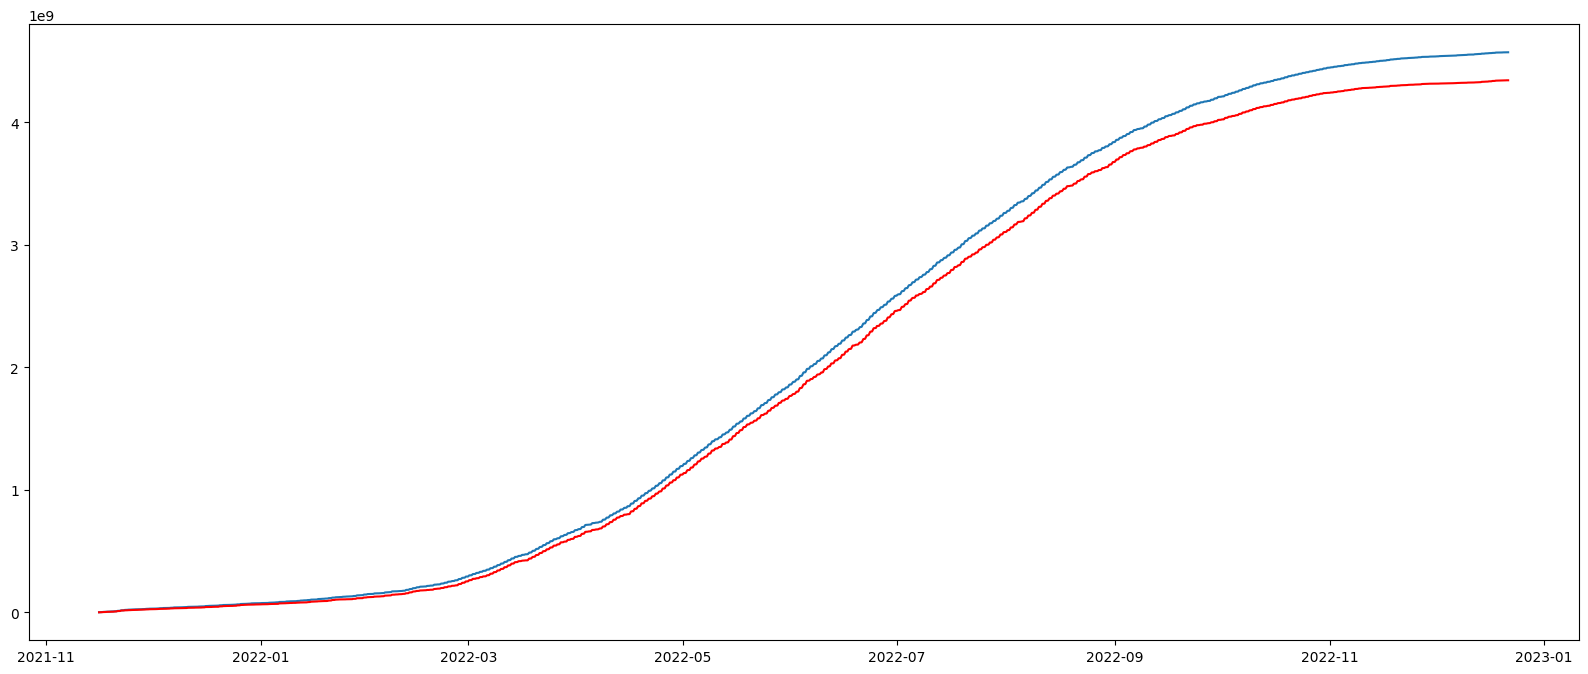

In [16]:
plt.plot(train_df["ssrd_diff"].cumsum() / 4)
plt.plot(train_df["measurements"].cumsum() * 10000, color = "red")

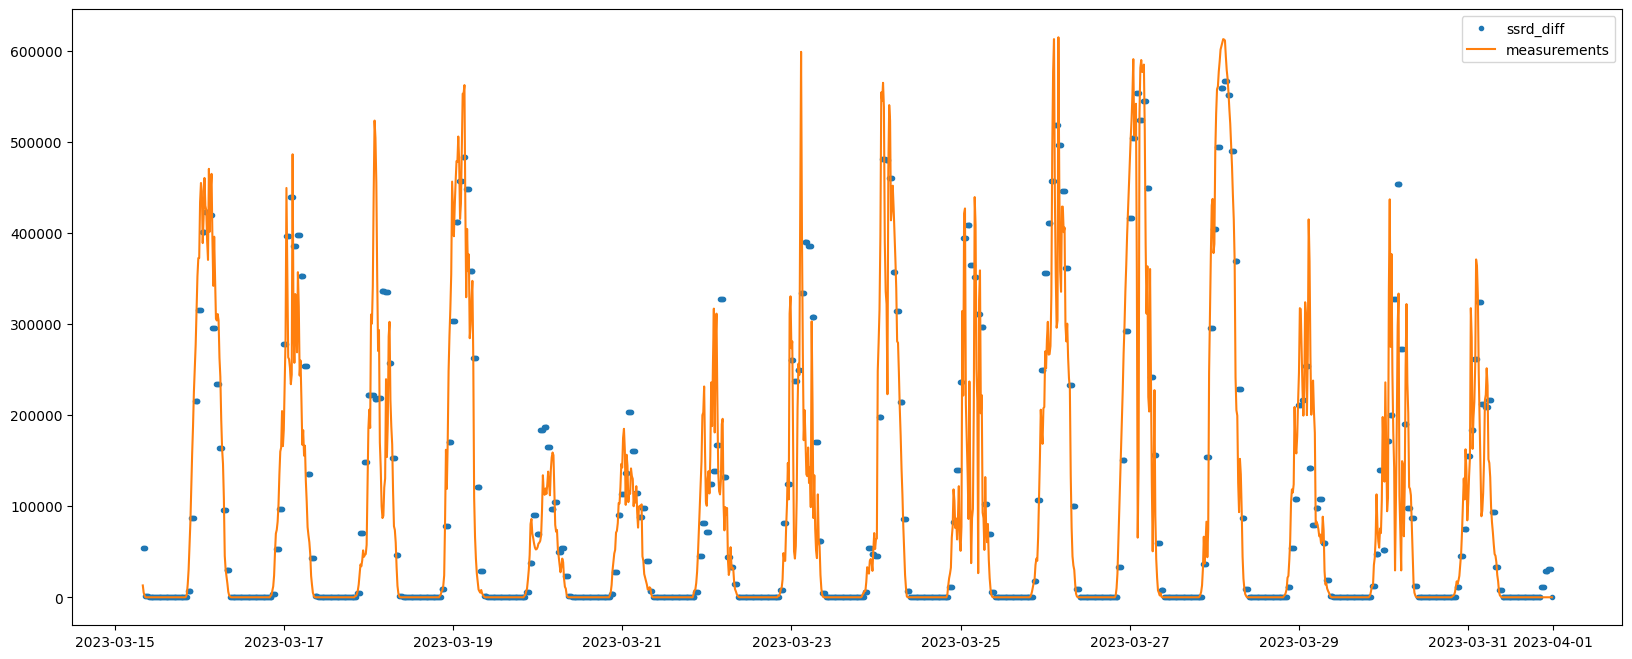

In [17]:
idx = 1600
plt.plot(Bast_train_data["ssrd_diff"].iloc[-idx:] / 4, ".", label = "ssrd_diff")
plt.plot(Bast_train_data["measurements"].iloc[-idx:] * 10000, label = "measurements")
plt.legend()
plt.show()

### Comparison between the radiation values and the target or feature

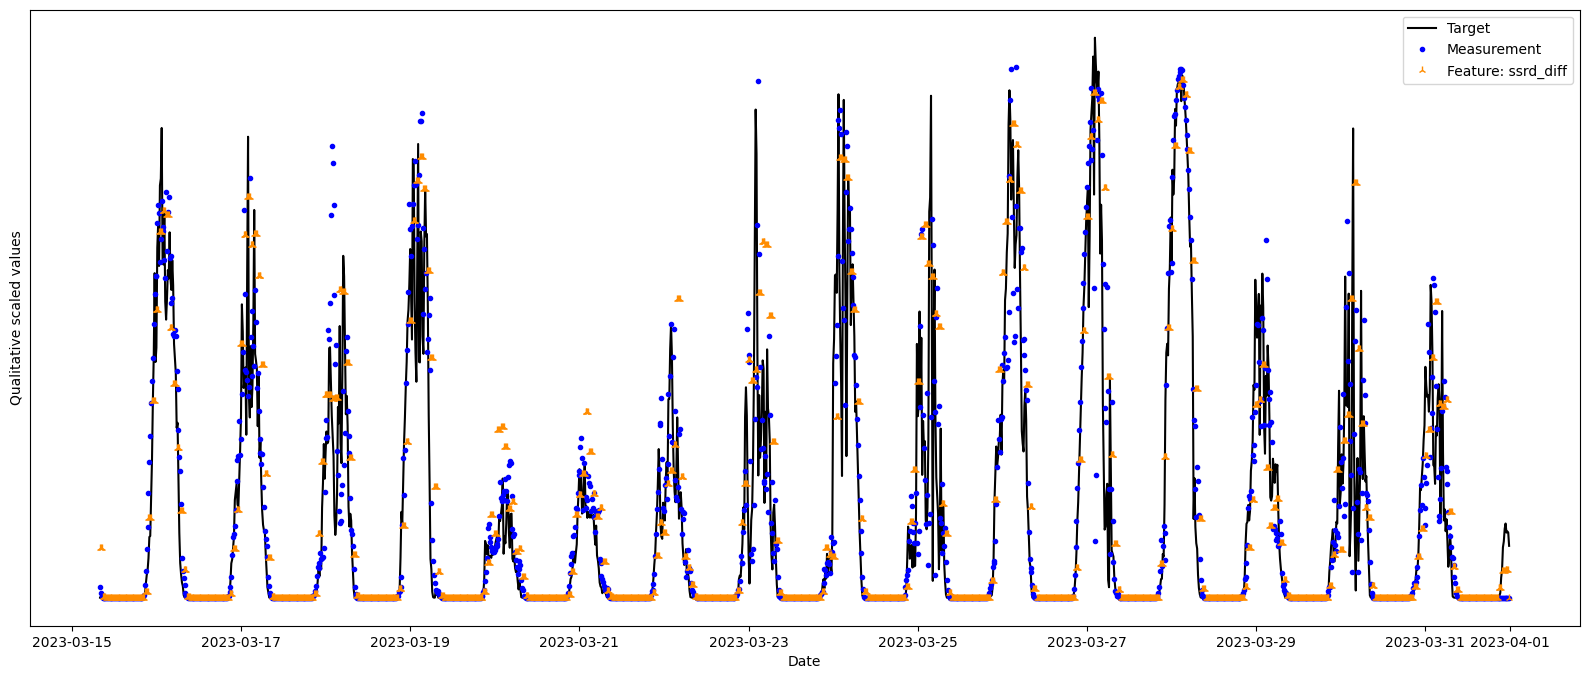

In [19]:

plt.plot(Bast_train_data["target"].iloc[-idx:], color="black", linestyle="-", label = "Target")
plt.plot(Bast_train_data["measurements"].iloc[-idx:] * 2100, color="blue", marker=".", linestyle="None", label = "Measurement")
plt.plot(Bast_train_data["ssrd_diff"].iloc[-idx:] / 18, color="darkorange", marker="2", linestyle="None", label = "Feature: ssrd_diff")
# Set the x-axis title
plt.xlabel('Date')
plt.yticks([])

# Set the y-axis title
plt.ylabel('Qualitative scaled values')
plt.legend()
plt.show()


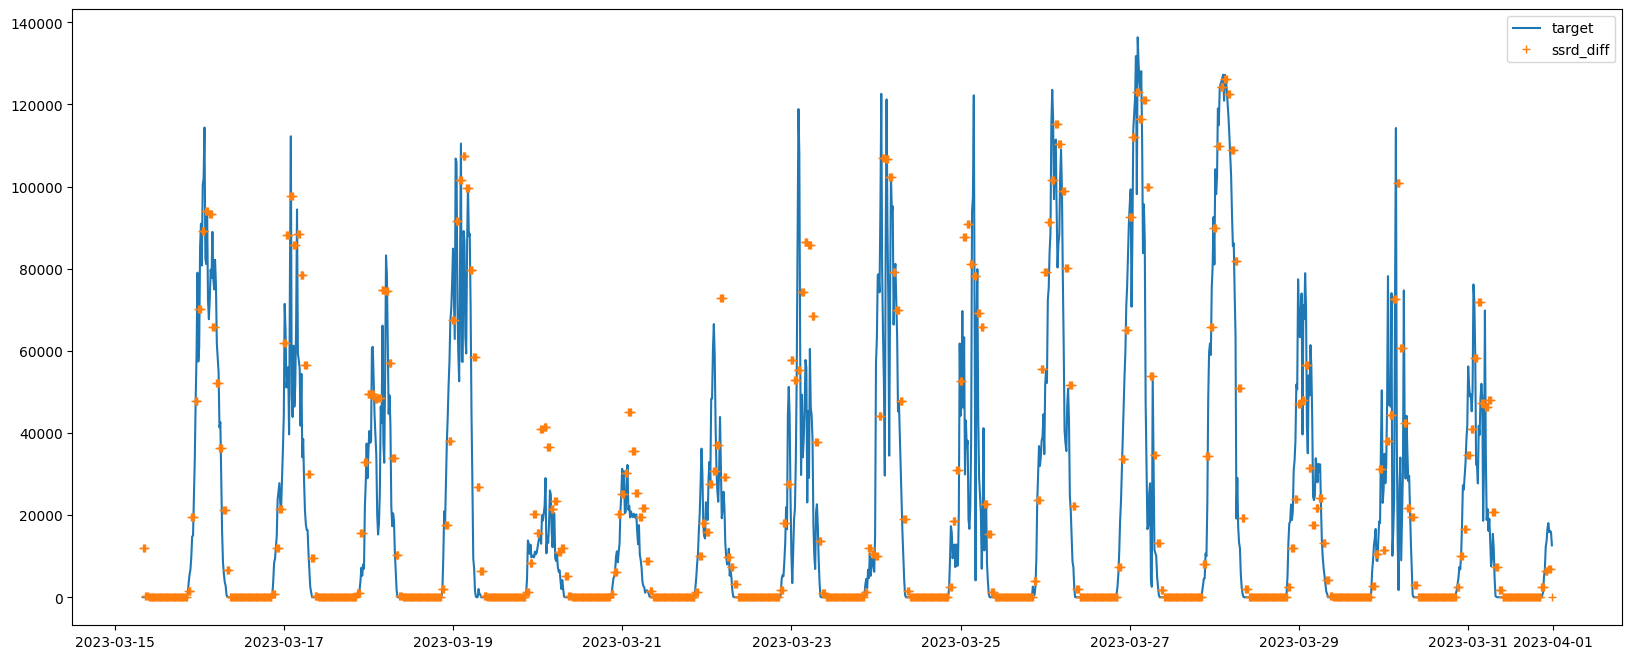

In [20]:
plt.plot(Bast_train_data["target"].iloc[-idx:], label = "target")
plt.plot(Bast_train_data["ssrd_diff"].iloc[-idx:] / 18, "+", label = "ssrd_diff")
plt.legend()
plt.show()

### Comparison between the predictions and the target

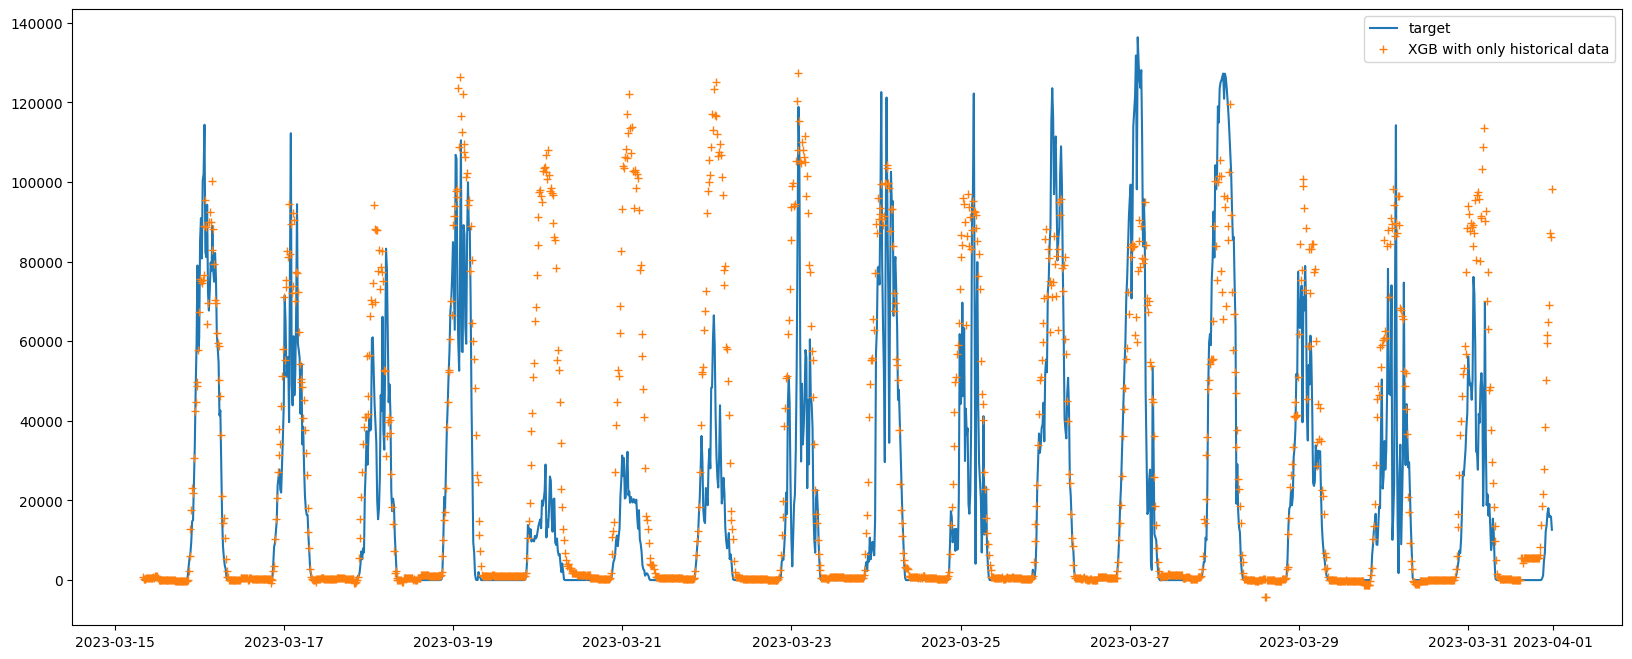

In [22]:
plt.plot(test_df["target"].iloc[-idx:], label = "target")
plt.plot(test_df.index[-idx:], y_pred_hist[-idx:], "+", label = "XGB with only historical data")
plt.legend()
plt.show()

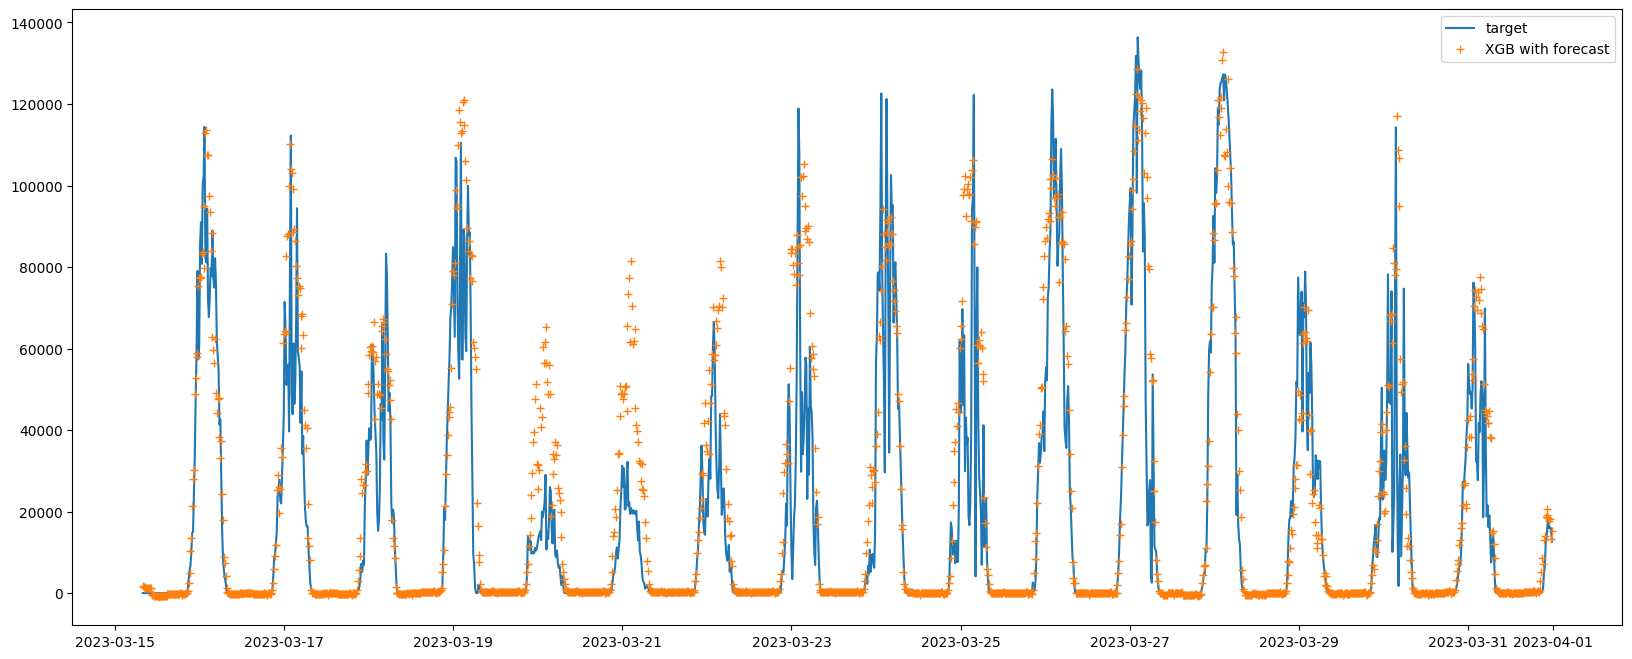

In [23]:
plt.plot(test_df["target"].iloc[-idx:], label = "target")
plt.plot(test_df.index[-idx:], ypred_ff[-idx:], "+", label = "XGB with forecast")
plt.legend()
plt.show()

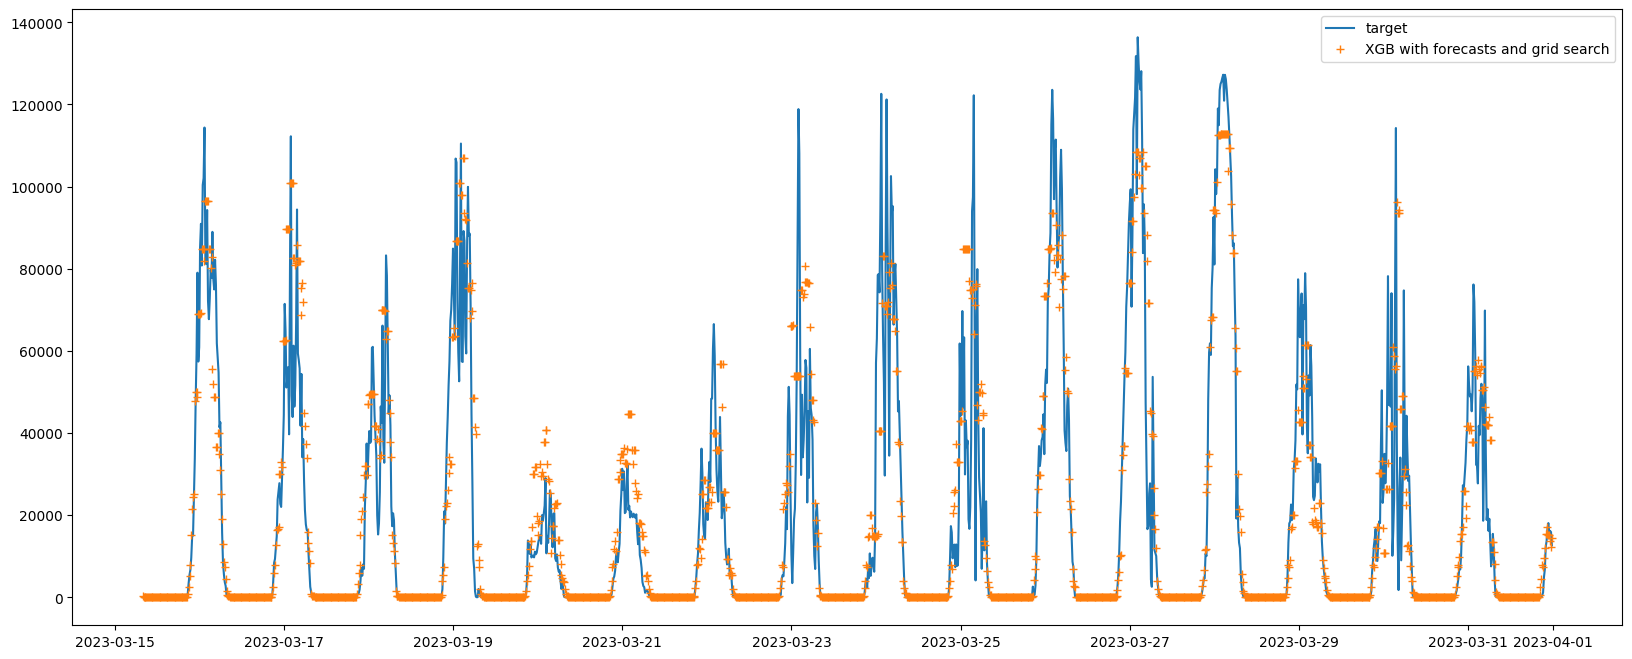

In [24]:
plt.plot(test_df["target"].iloc[-idx:], label = "target")
plt.plot(test_df.index[-idx:], ypred_ff_gs[-idx:], "+", label = "XGB with forecasts and grid search")
plt.legend()
plt.show()

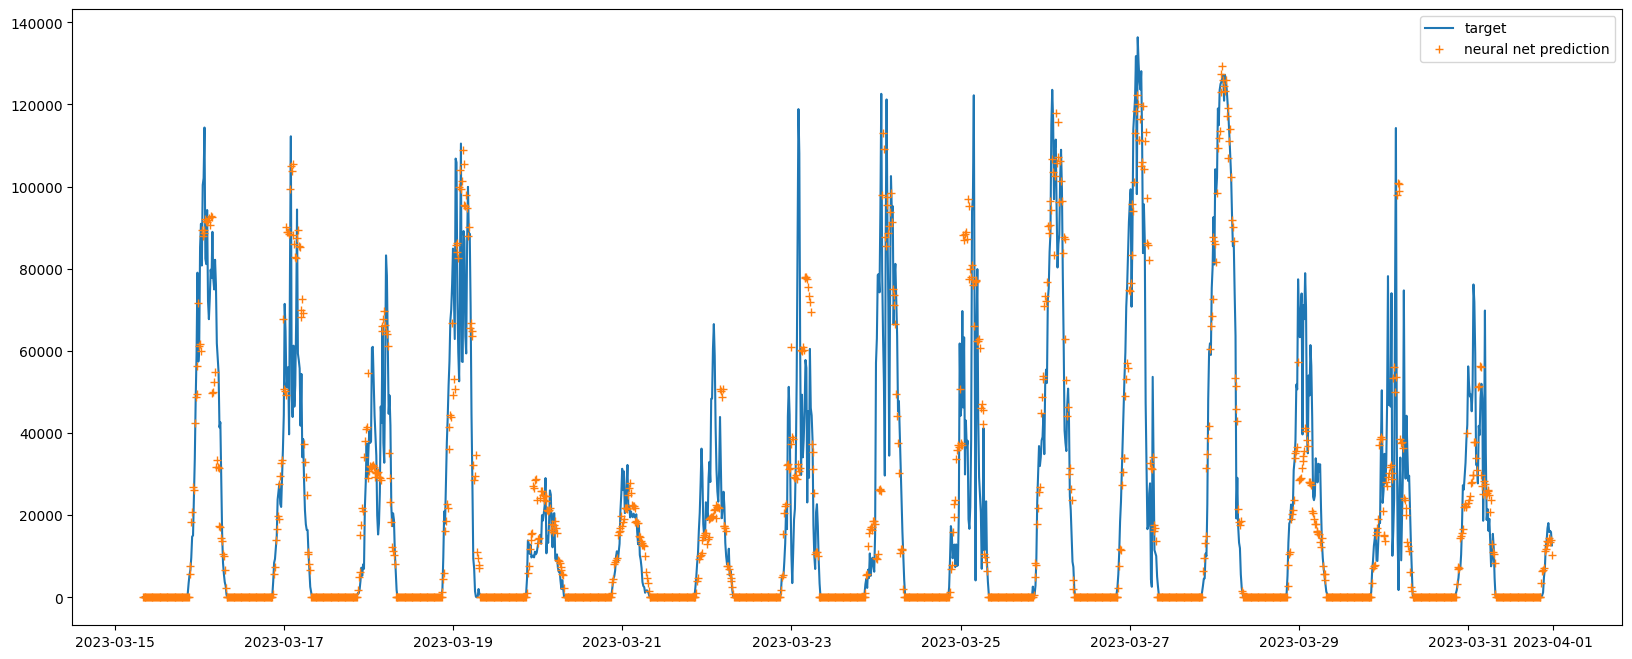

In [25]:
plt.plot(test_df["target"].iloc[-idx:], label = "target")
plt.plot(test_df.index[-idx:], y_pred_nn[-idx:], "+", label = "neural net prediction")
plt.legend()
plt.show()

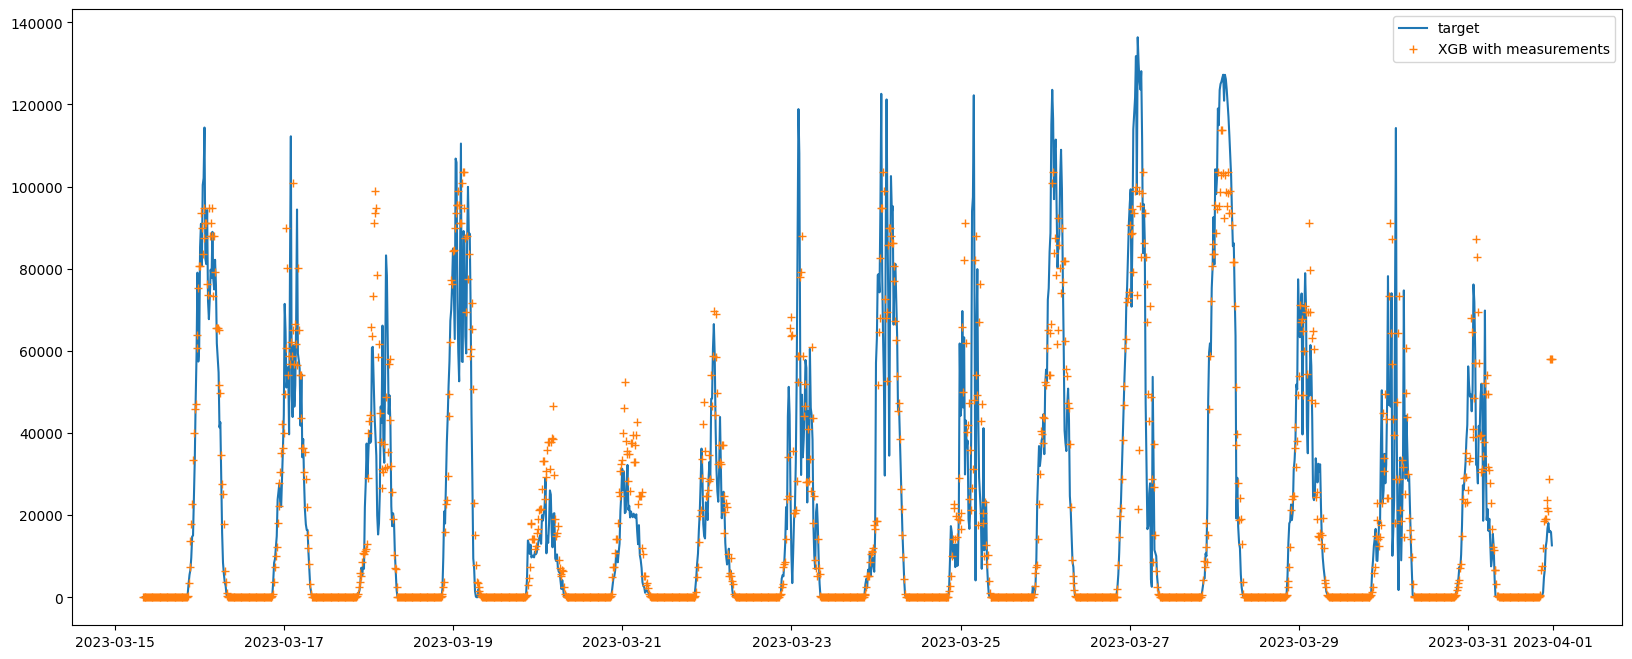

In [26]:
plt.plot(test_df["target"].iloc[-idx:], label = "target")
plt.plot(test_df.index[-idx:], y_pred_mm[-idx:], "+", label = "XGB with measurements")
plt.legend()
plt.show()

# Prediction Error tendency


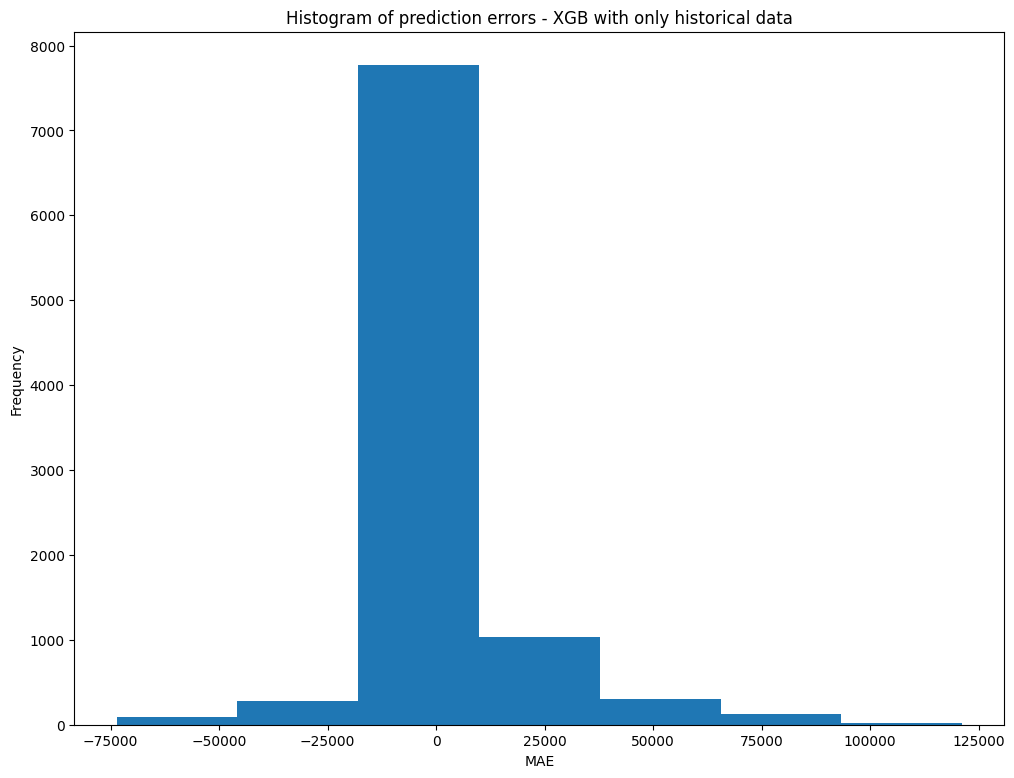

In [27]:
import matplotlib.pyplot as plt

data = y_pred_hist - test_df["target"]
num_bins = 7

fig, ax = plt.subplots(figsize=(12, 9))  # 4:3 ratio (width: 12 inches, height: 9 inches)
ax.hist(data, bins=num_bins, range=(data.min(), data.max()), align='mid', rwidth=1)
ax.set_xlabel('MAE')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of prediction errors - XGB with only historical data') 

plt.show()


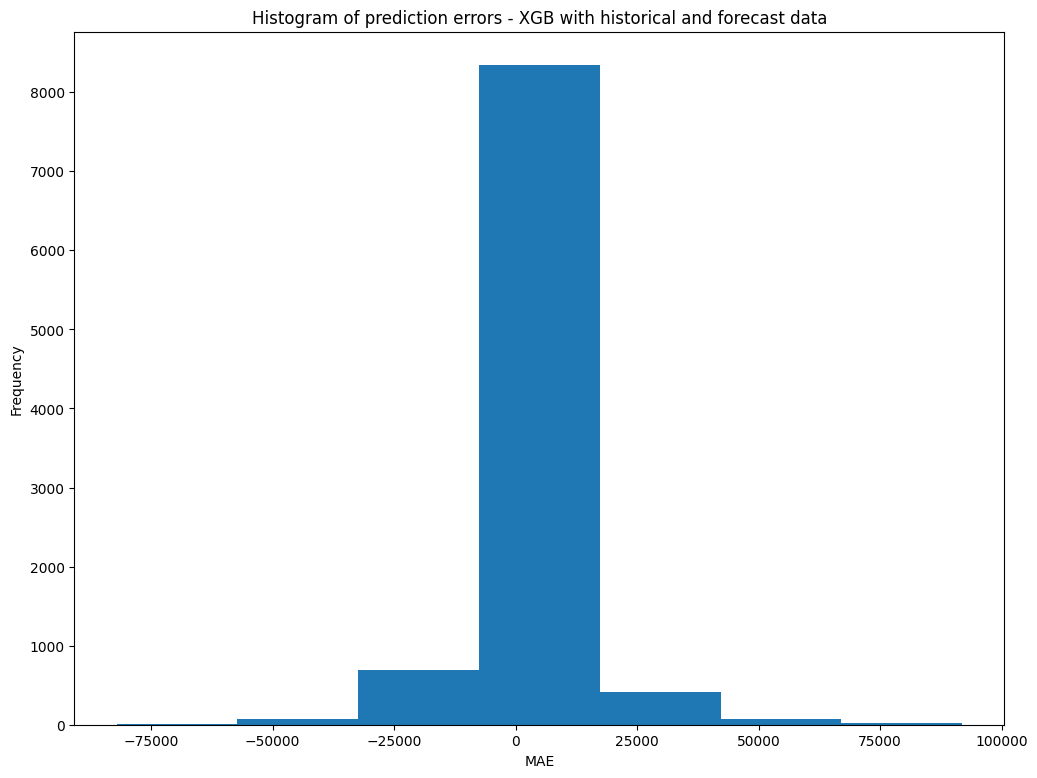

In [30]:
import matplotlib.pyplot as plt

data = ypred_ff_gs - test_df["target"]
num_bins = 7

fig, ax = plt.subplots(figsize=(12, 9))  # 4:3 ratio (width: 12 inches, height: 9 inches)
ax.hist(data, bins=num_bins, range=(data.min(), data.max()), align='mid', rwidth=1)
ax.set_xlabel('MAE')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of prediction errors - XGB with historical and forecast data') 

plt.show()


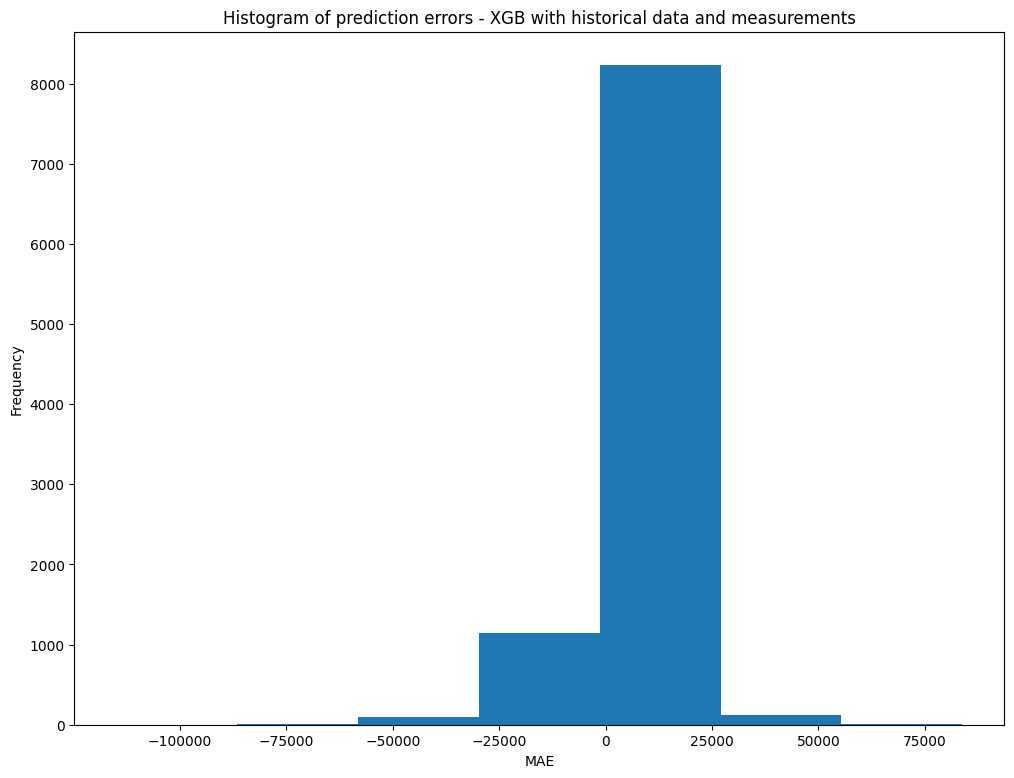

In [31]:
import matplotlib.pyplot as plt

data = y_pred_mm - test_df["target"]
num_bins = 7

fig, ax = plt.subplots(figsize=(12, 9))  # 4:3 ratio (width: 12 inches, height: 9 inches)
ax.hist(data, bins=num_bins, range=(data.min(), data.max()), align='mid', rwidth=1)
ax.set_xlabel('MAE')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of prediction errors - XGB with historical data and measurements') 

plt.show()


# Run the predictions with different shifts 

Essentially the shifts decide how far into the future we are forecasting.


In [25]:
start_date = "2021-11-16"
end_date = "2023-04-01"
SHIFTS = [1, 2, 4, 8, 16, 24, 48, 96]
y_pred_hist = []
y_pred_mm = []
y_pred_nn = []
y_pred_fc_gs = [] 
mae_hist = []
mae_mm = []
mae_nn = []
mae_fc_gs = []
# historical PV data for Bastorf
for idx, shift in enumerate(SHIFTS):
    Bast_train_data = datasets["Bastorf"].data(shift)
    Bast_train_data.index = Bast_train_data.index.tz_convert(None).to_series().astype('datetime64[ns]')
    Bast_train_data = Bast_train_data[(Bast_train_data.index >= pd.to_datetime(start_date)) & (Bast_train_data.index < pd.to_datetime(end_date))]


    # forecast data for Bastorf
    weather_fc = pd.read_parquet("data/Bastorf_01012021-15052020_36steps.parquet")
    weather_fc = create_forecast_df(weather_fc, shift, forecasts_per_day=2 , index=1, start_date=start_date, end_date=end_date, diff=True)

    # add measurements to the forecast data
    measurements = pd.read_csv("data/csv_electricity_informatics.csv")
    measurements["MESS_DATUM"] = pd.to_datetime(measurements["MESS_DATUM"], format="%Y%m%d%H%M")
    # filter for the time period
    measurements = measurements[(measurements["MESS_DATUM"] >= pd.to_datetime(start_date)) & (measurements["MESS_DATUM"] < pd.to_datetime(end_date))]
    # account for the shift
    measurements = measurements.iloc[shift:]
    new_rows = pd.DataFrame(0, index=range(shift), columns=measurements.columns)
    measurements = pd.concat([measurements, new_rows]).reset_index(drop=True)
    measurements["GS_10"] = measurements["GS_10"].apply(lambda x: max(x, 0))

    # add measurements to the train dataframe


    # combine measurements, historical and forecast data
    Bast_train_data["ssrd_diff"] = weather_fc["ssrd_diff"].values
    Bast_train_data["ssr_diff"] = weather_fc["ssr_diff"].values
    Bast_train_data["measurements"] = measurements["GS_10"].values
    Bast_train_data = Bast_train_data[Bast_train_data["target"] > 7000]

    #construct training and test datasets
    train_df, test_df = train_test_split(Bast_train_data, shift_steps=shift, train_split=0.8) 

    # ______________________________________________________________________________________________
    # Train model with only hist. features
    print("HISTORICAL DATA ONLY")
    feat_cols = train_df.columns.drop("target").drop("ssrd_diff").drop("ssr_diff").drop("measurements")
    feature_selector = ColumnTransformer(
        [("selector", "passthrough", feat_cols)],
        remainder="drop",
        )
    model = Pipeline(
                [
                    ("column_selector", feature_selector),
                    ("scaler", StandardScaler()),
                    ("model", XGBRegressor(scoring=make_scorer(mean_absolute_error, greater_is_better=False))),
                ]
            )


    model.fit(train_df[feat_cols], train_df["target"])
    ytrue = test_df["target"]
    # Make predictions
    y_pred_hist.append(model.predict(test_df[feat_cols]))

    # Calculate metrics
    mse = mean_squared_error(test_df["target"], y_pred_hist[idx])
    mae = mean_absolute_error(test_df["target"], y_pred_hist[idx]) / test_df["target"].mean()
    mae_hist.append(mae)
    r2 = r2_score(test_df["target"], y_pred_hist[idx])

    # Print metrics
    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    print('R-squared:', r2)
     # ______________________________________________________________________________________________
    print("HISTORICAL DATA + FORECAST")
    feat_cols = train_df.columns.drop("target").drop("measurements")
    feature_selector = ColumnTransformer(
            [("selector", "passthrough", feat_cols)],
            remainder="drop",
            )

    param_grid = {    
        #"min_child_weight": [1, 2], #1    
        #"n_estimators": [100, 200], #100    
        "n_estimators": [10], #100    
        #"gamma": [1.5],    
        #"subsample": [0.6],    
        #"colsample_bytree": [0.8, 1], #1    
        #"max_depth": [4, 6], #6    
        #"learning_rate": [0.1, 0.3], #0.3    
    }  

    model = Pipeline(
                    [
                        ("column_selector", feature_selector),
                        ("model", GridSearchCV(XGBRegressor(), param_grid=param_grid, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=5)),
                    ]
                )


    model.fit(train_df[feat_cols], train_df["target"])

    # Make predictions
    y_pred_fc_gs.append(model.predict(test_df[feat_cols]))

    # Calculate metrics
    mse = mean_squared_error(test_df["target"], y_pred_fc_gs[idx])
    mae = mean_absolute_error(test_df["target"], y_pred_fc_gs[idx]) / test_df["target"].mean()
    mae_fc_gs.append(mae)
    r2 = r2_score(test_df["target"], y_pred_fc_gs[idx])

    # Print metrics
    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    print('R-squared:', r2)
    # ______________________________________________________________________________________________
    print("NEURAL NET")
    import torch
    from torch.utils.data import TensorDataset, DataLoader
    from torch import nn, optim

    features = Bast_train_data.drop('target', axis=1).drop('measurements', axis = 1).values
    targets = Bast_train_data[['target']].values

    # Convert features and targets to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float)
    targets_tensor = torch.tensor(targets, dtype=torch.float)

    # Create a TensorDataset and DataLoader for easy batch processing
    dataset = TensorDataset(features_tensor, targets_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define the neural network
    model = nn.Sequential(
        nn.Linear(features.shape[1], 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU(),
        nn.Linear(4, 1)
    )
    # Define the loss function and optimizer
    loss_fn = nn.L1Loss() 
    optimizer = optim.Adam(model.parameters(), lr=7e-4)

    # Train the model
    for epoch in range(50):  # number of epochs
        for batch_features, batch_targets in dataloader:
            # Forward pass
            output = model(batch_features)
            loss = loss_fn(output, batch_targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:  # Print the loss every 10 epochs
            print(f"Epoch {epoch+1}/{500}, Loss: {loss.item()}")

    test_features = test_df.drop('target', axis=1).drop("measurements", axis=1).values
    test_targets = test_df[['target']].values

    # Convert test features and targets to PyTorch tensors
    test_features_tensor = torch.tensor(test_features, dtype=torch.float)
    test_targets_tensor = torch.tensor(test_targets, dtype=torch.float)

    # Create a TensorDataset and DataLoader for the test data
    test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    # Switch to evaluation mode
    model.eval()

    # Disable gradient computations
    y_pred = []
    with torch.no_grad():
        test_loss = 0
        for test_features, test_targets in test_dataloader:
            # Forward pass
            test_output = model(test_features)
            y_pred.append(test_output)
            loss = loss_fn(test_output, test_targets)
            test_loss += loss.item()

        print("Test Loss: ", test_loss / len(test_dataloader))
        mae_nn.append(test_loss / (test_df["target"].mean() * len(test_dataloader)))
        


    y_pred = torch.cat(y_pred, dim=0).numpy()
    # Flatten the prediction and target arrays
    y_pred = y_pred.flatten()
    y_pred_nn.append(y_pred)
    test_targets_tensor = test_targets_tensor.numpy().flatten()

    # ______________________________________________________________________________________________
    print("HISTORICAL DATA + MEASUREMENTS")
    feat_cols = train_df.columns.drop("target").drop("ssrd_diff").drop("ssr_diff")
    feature_selector = ColumnTransformer(
            [("selector", "passthrough", feat_cols)],
            remainder="drop",
            )

    param_grid = {    
        #"min_child_weight": [1, 2], #1    
        #"n_estimators": [100, 200], #100    
        "n_estimators": [10], #100    
        #"gamma": [1.5],    
        #"subsample": [0.6],    
        #"colsample_bytree": [0.8, 1], #1    
        #"max_depth": [4, 6], #6    
        #"learning_rate": [0.1, 0.3], #0.3    
    }  

    model = Pipeline(
                    [
                        ("column_selector", feature_selector),
                        ("model", GridSearchCV(XGBRegressor(), param_grid=param_grid, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=5)),
                    ]
                )


    model.fit(train_df[feat_cols], train_df["target"])

    # Make predictions
    y_pred_mm.append(model.predict(test_df[feat_cols]))

    # Calculate metrics
    mse = mean_squared_error(test_df["target"], y_pred_mm[idx])
    mae = mean_absolute_error(test_df["target"], y_pred_mm[idx]) /  test_df["target"].mean()
    mae_mm.append(mae)
    r2 = r2_score(test_df["target"], y_pred_mm[idx])

    # Print metrics
    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    print('R-squared:', r2)


(64380, 7)
(64380, 9)
(40774, 9)
(37074, 9)
900000000000
44100000000000.0
(12024, 9)
   time  step  number  surface  latitude  longitude  valid_time  ssr_diff  \
0     0     0       0        0         0          0           0         0   

   ssrd_diff  
0          0  
(48095, 9)
(48096, 9)
HISTORICAL DATA ONLY
Mean Squared Error: 122179081.4663798
Mean Absolute Error: 0.213900584561961
R-squared: 0.8240486763264865
HISTORICAL DATA + FORECAST
Mean Squared Error: 107290743.23601641
Mean Absolute Error: 0.2039345524954986
R-squared: 0.8454895219073421
NEURAL NET
Epoch 1/500, Loss: 7079.30712890625
Epoch 11/500, Loss: 6309.63134765625
Epoch 21/500, Loss: 7335.65283203125
Epoch 31/500, Loss: 6650.73828125
Epoch 41/500, Loss: 3353.234375
Test Loss:  6138.239228805693
HISTORICAL DATA + MEASUREMENTS
Mean Squared Error: 109571978.76966235
Mean Absolute Error: 0.20110658679607968
R-squared: 0.8422042916785772
(64380, 7)
(64380, 9)
(40774, 9)
(37074, 9)
1800000000000
45000000000000.0
(12024, 9)


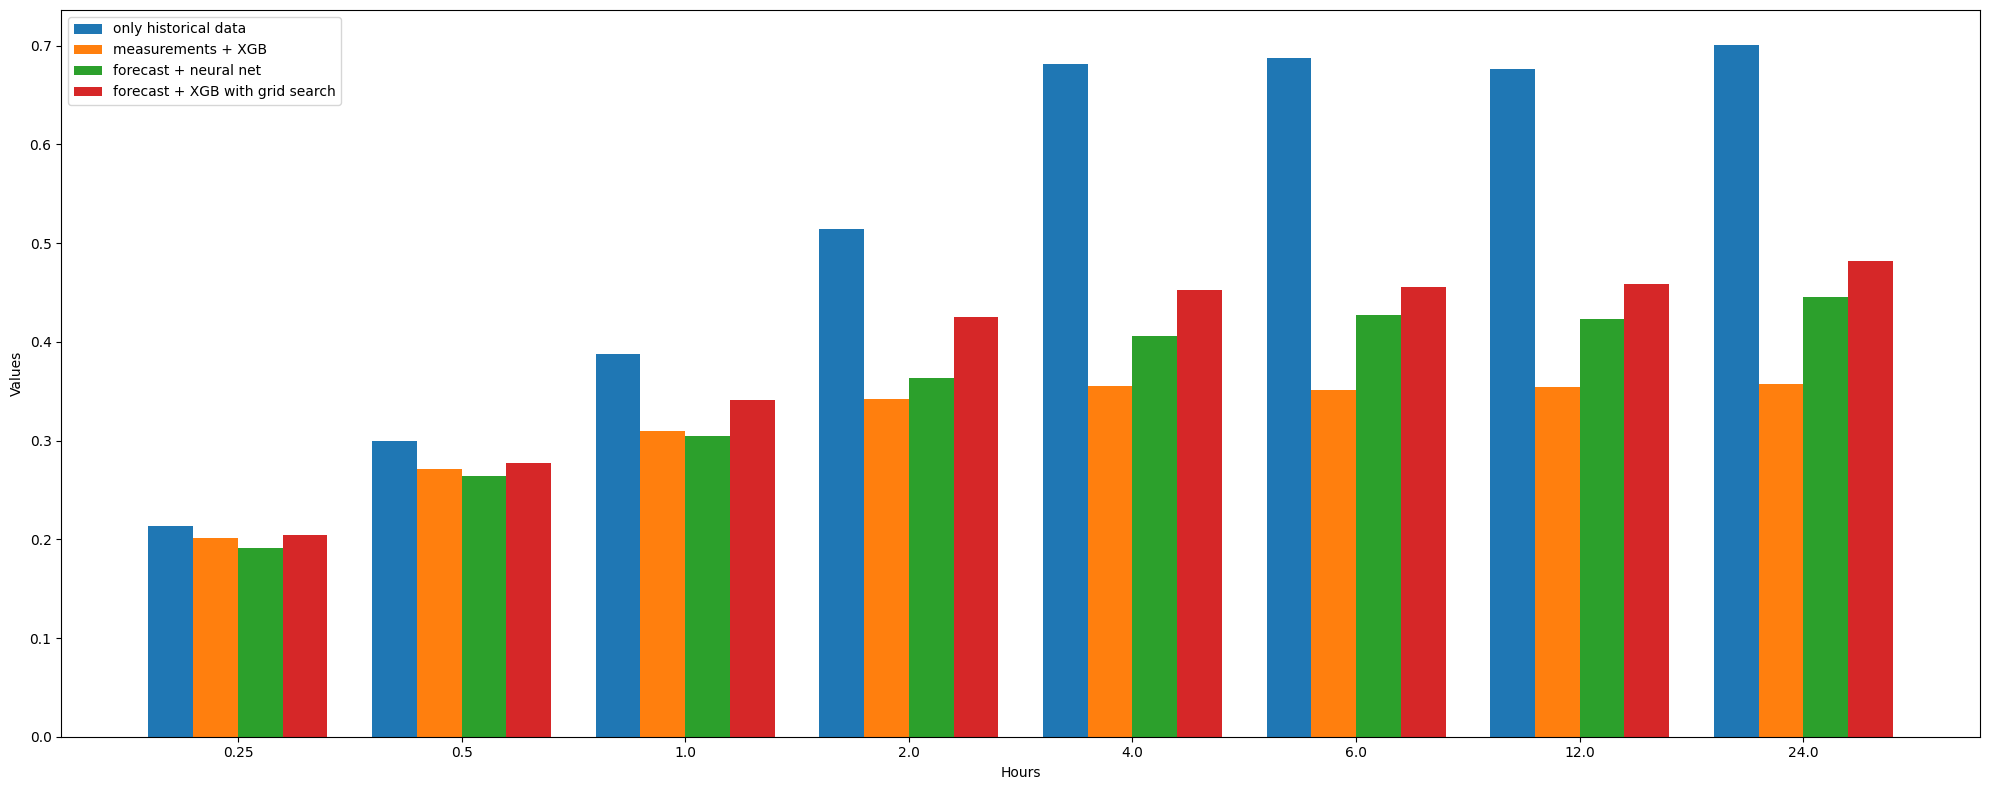

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bars(y_values, x_labels, y_label):
    x = np.arange(len(x_labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 3/2*width, y_values[0], width, label='only historical data')
    rects2 = ax.bar(x - width/2, y_values[1], width, label='measurements + XGB')
    rects3 = ax.bar(x + width/2, y_values[2], width, label='forecast + neural net')
    rects4 = ax.bar(x + 3/2*width, y_values[3], width, label='forecast + XGB with grid search')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Hours')
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    fig.tight_layout()

    plt.show()


x_labels = list(map(lambda x: x / 4, SHIFTS))  
y_values = [mae_hist, mae_mm, mae_nn, mae_fc_gs]
y_label = 'Values'
plot_bars(y_values, x_labels, y_label)



